In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import viridis

# 1. Initial Exploration

In [3]:
# First load dictionary with all data
with open('subx/all_data.pickle', 'rb') as f:
    data = pickle.load(f)

In [4]:
# print keys
print(data.keys())

x, y, rand_inds = data['x'], data['y'], data['rand_inds']

'''
X is the 3 day (overlapping) average ensemble rainfall predictions.
Before use w/ proposed method I computed its log+1 transform (i.e. x = log(1 + x) )
and also standardized. The data in the pickle has not been log-transformed or standardized.
Dimensions of x are:
    # of weekly model simulations (939)
    # of models in ensemble (11)
    numerical model rainfall predictions for 7 day averages
    spatial height (29)
    spatial width (59)
'''
print('x shape: ', x.shape)

'''
Y is the observed 3 day average rainfall 10 days in advance.
No further transformations were made before use w/ proposed method.
Dimensions of y are:
    # of weekly model simulations (939)
    ignore this axis
    spatial height (29)
    spatial width (59)
'''
print('y shape: ', y.shape)


# Compute ensemble mean
ens_mean = np.nanmean(x[:, :, -1], axis=1)
# Print MSE of ensemble mean
print('Ensemble mean error: ', np.nanmean(np.square(ens_mean - y[:, 0])))

dict_keys(['rand_inds', 'y', 'x'])
x shape:  (939, 11, 7, 29, 59)
y shape:  (939, 1, 29, 59)
Ensemble mean error:  15.622858


In [5]:
# Randomly shuffle x and y according to the 4th seed
seed = 4
shuffled_x = x[rand_inds[:, seed]]
shuffled_y = y[rand_inds[:, seed]]

In [6]:
# Divide into train, validation and test sets
train_size = 450
val_size = 250
test_size = shuffled_x.shape[0] - train_size - val_size
x_train, x_val, x_test = shuffled_x[:train_size], shuffled_x[train_size:train_size + val_size], shuffled_x[-test_size:]
y_train, y_val, y_test = shuffled_y[:train_size], shuffled_y[train_size:train_size + val_size], shuffled_y[-test_size:]


print('training data: ', x_train.shape, y_train.shape)
print('validation data: ', x_val.shape, y_val.shape)
print('testing data: ', x_test.shape, y_test.shape)

training data:  (450, 11, 7, 29, 59) (450, 1, 29, 59)
validation data:  (250, 11, 7, 29, 59) (250, 1, 29, 59)
testing data:  (239, 11, 7, 29, 59) (239, 1, 29, 59)


In [7]:
x_transformed = np.log(x + 1)
mu, sigma = np.nanmean(x_transformed[:test_size]), np.nanstd(x_transformed[:test_size])
x_transformed = (x_transformed - mu) / sigma
y_no_nan = np.copy(y)
y_no_nan[np.isnan(y)] = 0

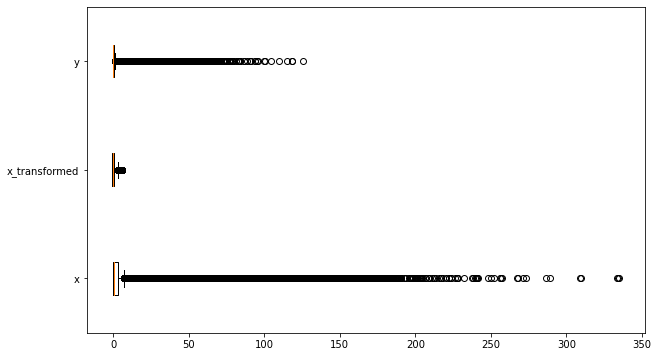

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.boxplot([x.ravel(), x_transformed.ravel(), y_no_nan.ravel()], labels=["x", "x_transformed", "y"], vert=False)
plt.show()

# 2. Figures for Paper

#### 2.1 Predictors

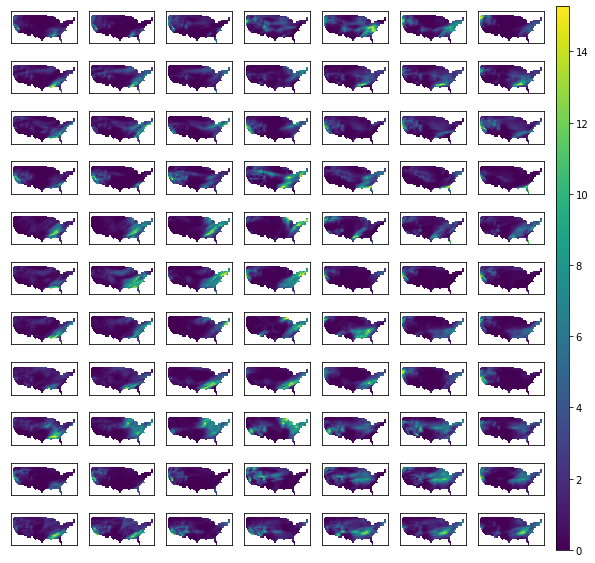

In [9]:
fig, ax = plt.subplots(11, 8, figsize=(10, 10), gridspec_kw={"width_ratios": [1 for _ in range(7)] + [0.2]})
img = np.copy(x[-1])
img[:, :, np.isnan(y[-1, 0, :, :])] = np.nan

# plot maps
for model in range(x.shape[1]):
    for day in range(x.shape[2]):
        m = ax[model, day].imshow(img[model, day])
        ax[model, day].set_xticks([])
        ax[model, day].set_yticks([])

# add colorbar
gs = ax[0, -1].get_gridspec()
for a in ax[:, -1]:
    a.remove()
cax = fig.add_subplot(gs[:, -1])
plt.colorbar(m, cax=cax)

# save and show
plt.savefig("fig/predictors.png")
plt.show()

#### 2.2 Targets

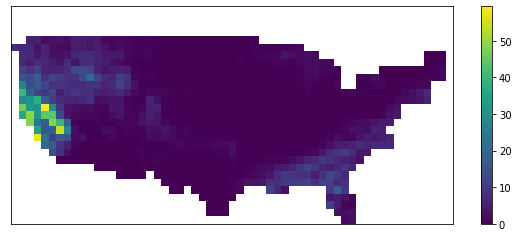

In [10]:
fig, ax = plt.subplots(figsize=(10, 4))
img = np.copy(y[-1, 0])
m = plt.imshow(img)
plt.colorbar(m)
plt.xticks([])
plt.yticks([])
plt.savefig("fig/targets.png")
plt.show()

#### 2.3 Marginal Historgram

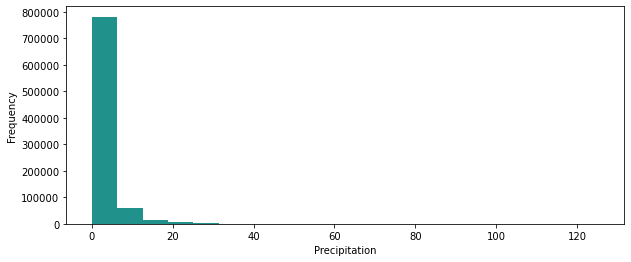

In [11]:
fig, ax = plt.subplots(figsize=(10, 4))
plt.hist(y.ravel(), bins=20, color=viridis(0.5))
plt.xlabel("Precipitation")
plt.ylabel("Frequency")
plt.savefig("fig/hist.png")
plt.show()

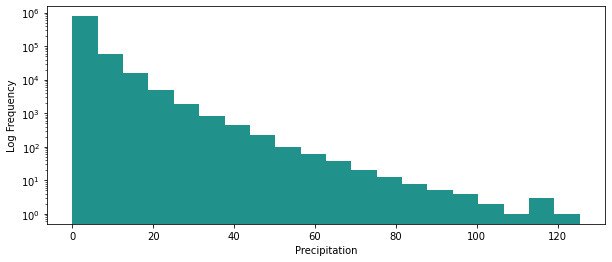

In [12]:
fig, ax = plt.subplots(figsize=(10, 4))
plt.hist(y.ravel(), bins=20, color=viridis(0.5), log=True)
plt.xlabel("Precipitation")
plt.ylabel("Log Frequency")
plt.savefig("fig/loghist.png")
plt.show()

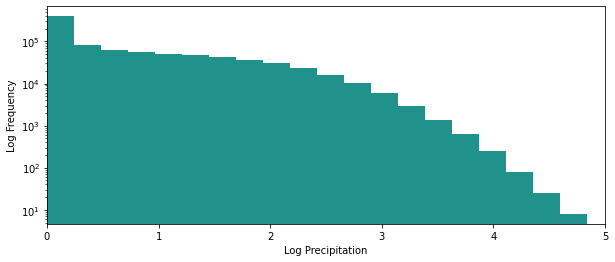

In [13]:
fig, ax = plt.subplots(figsize=(10, 4))
plt.hist(np.log(1 + y.ravel()), bins=20, color=viridis(0.5), log=True)
plt.xlabel("Log Precipitation")
plt.ylabel("Log Frequency")
plt.xlim((0, 5))
plt.savefig("fig/logloghist.png")
plt.show()

#### 2.4 Location Histogram

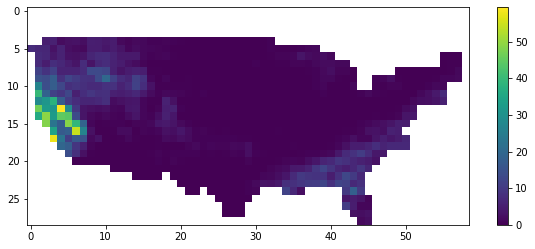

In [14]:
fig, ax = plt.subplots(figsize=(10, 4))
img = np.copy(y[-1, 0])
m = plt.imshow(img)
plt.colorbar(m)
plt.savefig("fig/grid.png")
plt.show()

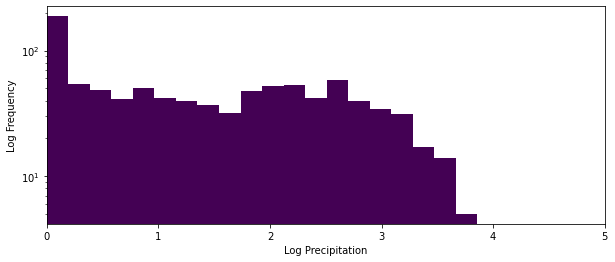

In [15]:
fig, ax = plt.subplots(figsize=(10, 4))
plt.hist(np.log(1 + y[:, 0, 5, 0].ravel()), bins=20, color=viridis(0), log=True)
plt.xlabel("Log Precipitation")
plt.ylabel("Log Frequency")
plt.xlim((0, 5))
plt.savefig("fig/washington_1.png")
plt.show()

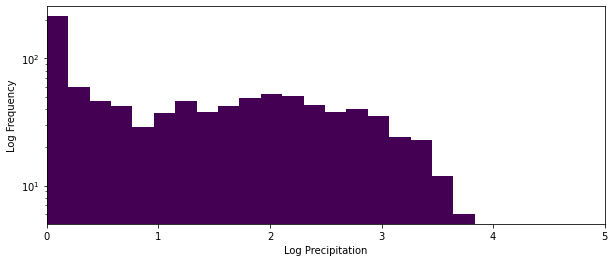

In [16]:
fig, ax = plt.subplots(figsize=(10, 4))
plt.hist(np.log(1 + y[:, 0, 5, 1].ravel()), bins=20, color=viridis(0), log=True)
plt.xlabel("Log Precipitation")
plt.ylabel("Log Frequency")
plt.xlim((0, 5))
plt.savefig("fig/washington_2.png")
plt.show()

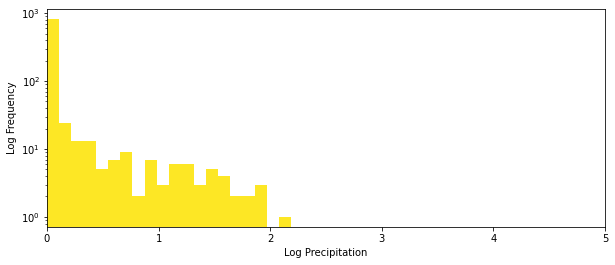

In [17]:
fig, ax = plt.subplots(figsize=(10, 4))
plt.hist(np.log(1 + y[:, 0, 20, 10].ravel()), bins=20, color=viridis(1.0), log=True)
plt.xlabel("Log Precipitation")
plt.ylabel("Log Frequency")
plt.xlim((0, 5))
plt.savefig("fig/arizona_1.png")
plt.show()

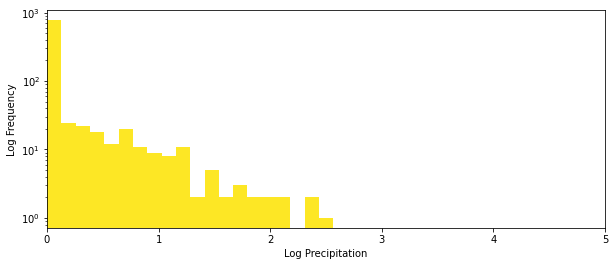

In [18]:
fig, ax = plt.subplots(figsize=(10, 4))
plt.hist(np.log(1 + y[:, 0, 20, 11].ravel()), bins=20, color=viridis(1.0), log=True)
plt.xlabel("Log Precipitation")
plt.ylabel("Log Frequency")
plt.xlim((0, 5))
plt.savefig("fig/arizona_2.png")
plt.show()

#### 2.5 Temporal Histogram

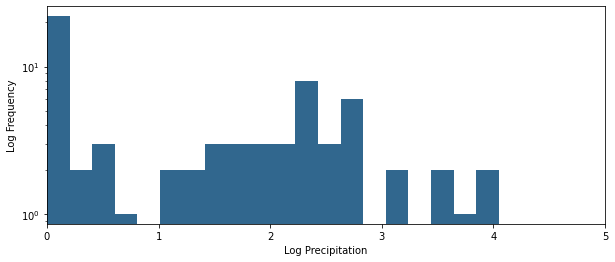

In [46]:
fig, ax = plt.subplots(figsize=(10, 4))
december = [((i % 52) - 48) // 4 == 0 for i in range(len(y))]
plt.hist(np.log(1 + y[december, 0, 15, 2].ravel()), bins=20, color=viridis(0.33), log=True)
plt.xlabel("Log Precipitation")
plt.ylabel("Log Frequency")
plt.xlim((0, 5))
plt.savefig("fig/california_winter_1.png")
plt.show()

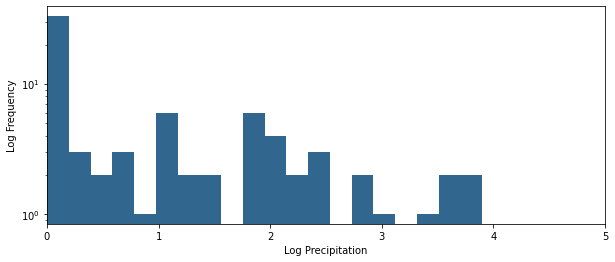

In [47]:
fig, ax = plt.subplots(figsize=(10, 4))
january = [(i % 52) // 4 == 0 for i in range(len(y))]
plt.hist(np.log(1 + y[january, 0, 15, 2].ravel()), bins=20, color=viridis(0.33), log=True)
plt.xlabel("Log Precipitation")
plt.ylabel("Log Frequency")
plt.xlim((0, 5))
plt.savefig("fig/california_winter_2.png")
plt.show()

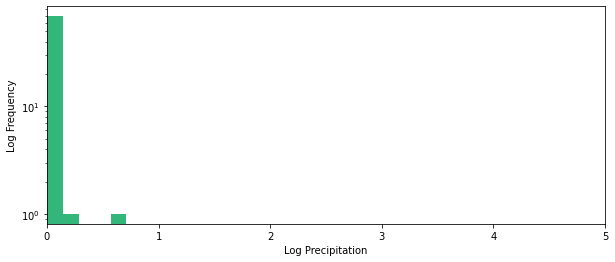

In [48]:
fig, ax = plt.subplots(figsize=(10, 4))
august = [((i % 52) - 32) // 4 == 0 for i in range(len(y))]
plt.hist(np.log(1 + y[august, 0, 15, 2].ravel()), bins=5, color=viridis(0.66), log=True)
plt.xlabel("Log Precipitation")
plt.ylabel("Log Frequency")
plt.xlim((0, 5))
plt.savefig("fig/california_summer_1.png")
plt.show()

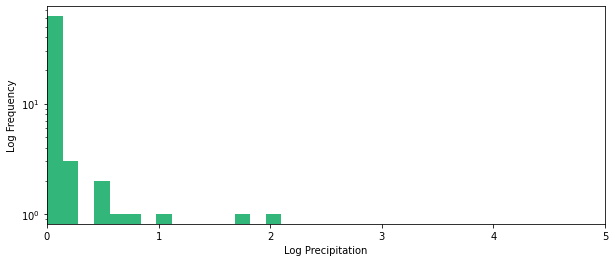

In [49]:
fig, ax = plt.subplots(figsize=(10, 4))
september = [((i % 52) - 36) // 4 == 0 for i in range(len(y))]
plt.hist(np.log(1 + y[september, 0, 15, 2].ravel()), bins=15, color=viridis(0.66), log=True)
plt.xlabel("Log Precipitation")
plt.ylabel("Log Frequency")
plt.xlim((0, 5))
plt.savefig("fig/california_summer_2.png")
plt.show()